<div align="center">
  <span style="color:#AC3E31; font-size:24px;"><strong>Install Packages</strong></span><br>
</div>

In [2]:
!pip install prophet plotly ipywidgets nbformat --upgrade --quiet
!pip install numpy scikit-learn tensorflow --quiet

<div align="center">
  <span style="color:#AC3E31; font-size:24px;"><strong>Import Packages</strong></span><br>
</div>

In [4]:
import pandas as pd
from prophet import Prophet
import plotly.graph_objects as go
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import plot_components
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

<div align="center">
  <span style="color:#AC3E31; font-size:24px;"><strong>Import Michigan Data</strong></span><br>
</div>

In [6]:
df = pd.read_csv("Data/michigan_data.csv")
df.head()

,state,year,month,tdmean,tmax,tmean,tmin,vpdmax,vpdmin,ppt,region,season
0,Michigan,1985,1,-11.501442,-4.234115,-8.484897,-12.736702,1.506011,0.275857,56.444954,Midwest,Winter
1,Michigan,1985,2,-10.713084,-2.677614,-7.705802,-12.735008,1.797285,0.260097,66.865008,Midwest,Winter
2,Michigan,1985,3,-4.473194,6.019074,0.515531,-4.988129,4.789973,0.506630,75.054134,Midwest,Spring
3,Michigan,1985,4,2.030085,14.128125,8.146787,2.166648,9.984798,0.878382,79.937412,Midwest,Spring
4,Michigan,1985,5,6.449573,20.940137,13.806332,6.673888,14.916078,1.183650,73.132215,Midwest,Spring


<div align="center">
  <span style="color:#AC3E31; font-size:24px;"><strong>Explore Data</strong></span><br>
</div>

In [8]:
df.info()
df.describe()
df['season'].unique()
df['year'].min(), df['year'].max()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   state   480 non-null    object 
 1   year    480 non-null    int64  
 2   month   480 non-null    int64  
 3   tdmean  480 non-null    float64
 4   tmax    480 non-null    float64
 5   tmean   480 non-null    float64
 6   tmin    480 non-null    float64
 7   vpdmax  480 non-null    float64
 8   vpdmin  480 non-null    float64
 9   ppt     480 non-null    float64
 10  region  480 non-null    object 
 11  season  480 non-null    object 
dtypes: float64(7), int64(2), object(3)
memory usage: 45.1+ KB


(1985, 2024)

<div align="center">
  <span style="color:#AC3E31; font-size:24px;"><strong>Seasonal Trends</strong></span><br>
</div>

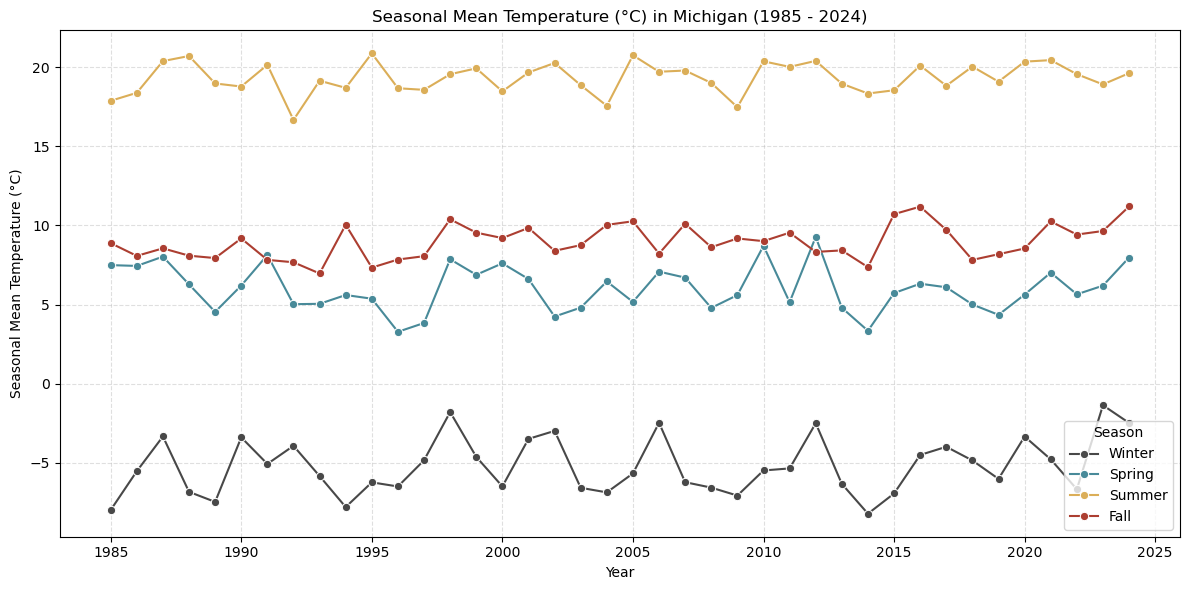

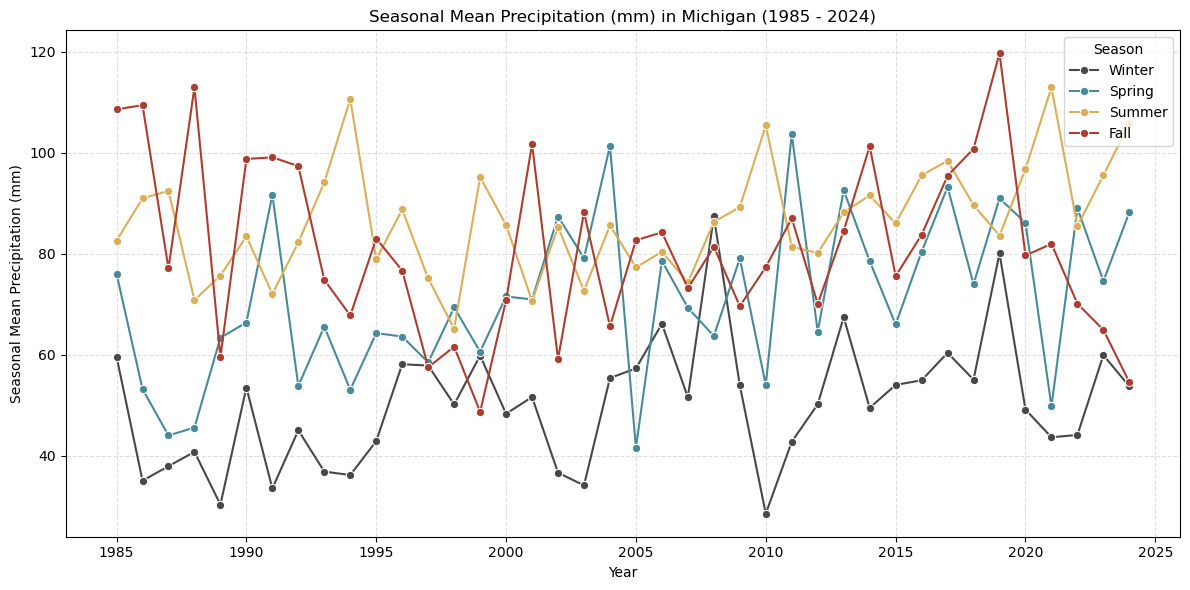

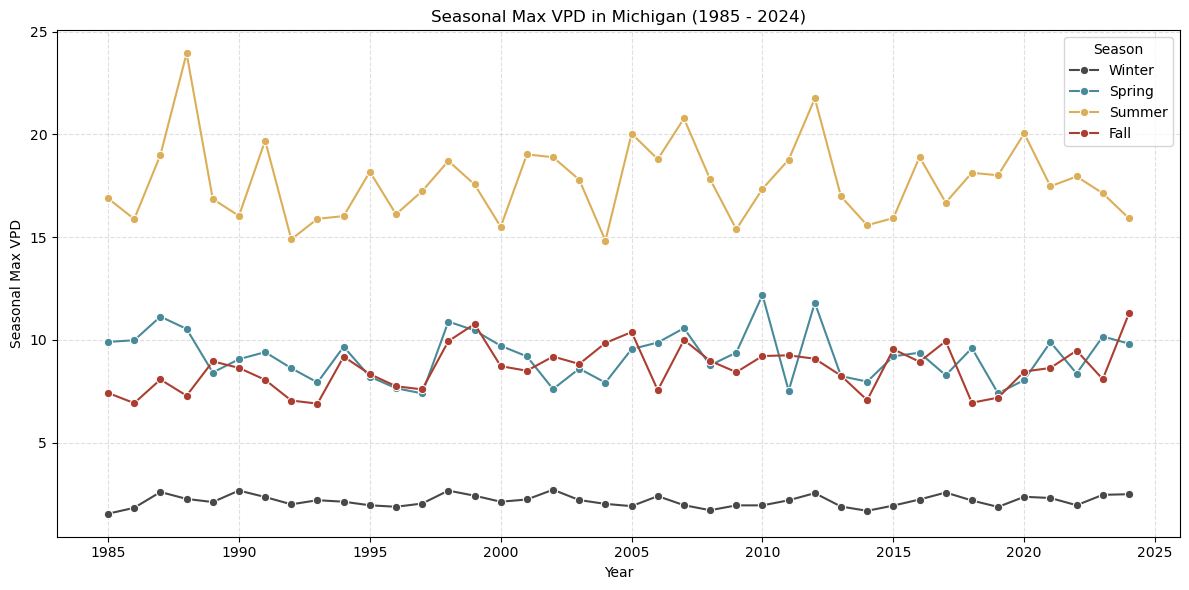

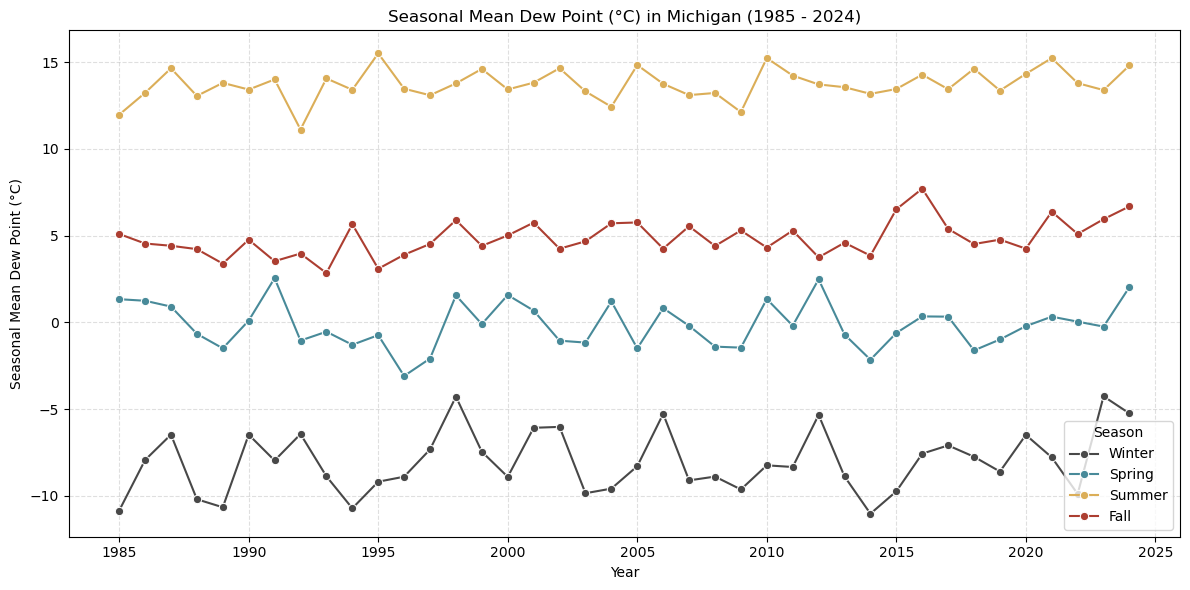

In [10]:
# Define season order and custom colors
season_order = ["Winter", "Spring", "Summer", "Fall"]
custom_palette = {
    "Winter": "#484848",
    "Spring": "#488A99",
    "Summer": "#DBAE58",
    "Fall": "#AC3E31"
}

# Variables and titles
variables = ['tmean', 'ppt', 'vpdmax', 'tdmean']
titles = {
    'tmean': "Seasonal Mean Temperature (°C)",
    'ppt': "Seasonal Mean Precipitation (mm)",
    'vpdmax': "Seasonal Max VPD",
    'tdmean': "Seasonal Mean Dew Point (°C)"
}

# Plot each variable
for var in variables:
    seasonal_trend = df.groupby(['year', 'season'])[var].mean().reset_index()
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=seasonal_trend,
        x='year',
        y=var,
        hue='season',
        hue_order=season_order,
        palette=custom_palette,
        marker="o"
    )
    plt.title(f"{titles[var]} in Michigan (1985 - 2024)")
    plt.xlabel("Year")
    plt.ylabel(titles[var])
    plt.legend(title='Season')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


<div align="center">
  <span style="color:#AC3E31; font-size:24px;"><strong>Baseline Forecasting Comparison: Naive vs Seasonal Naive</strong></span><br>
</div>

In [48]:
# Load data
df = pd.read_csv("Data/michigan_data.csv")
df['ds'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Variables to evaluate
variables = ['tmean', 'ppt', 'tdmean', 'vpdmax']
rmse_results = []

for var in variables:
    # Filter and prepare data
    df_var = df[['ds', var]].dropna().set_index('ds')
    
    # Naive forecast: value = previous month
    naive_forecast = df_var[var].shift(1)
    
    # Seasonal naive forecast: value = same month last year
    seasonal_naive = df_var[var].shift(12)
    
    # Align actual values
    actual = df_var[var].dropna()
    actual = actual.loc[seasonal_naive.dropna().index]  # Align with seasonal forecast

    # Calculate RMSE
    naive_rmse = np.sqrt(mean_squared_error(actual, naive_forecast.loc[actual.index]))
    seasonal_rmse = np.sqrt(mean_squared_error(actual, seasonal_naive.loc[actual.index]))
    
    rmse_results.append({
        'Variable': var.upper(),
        'Naive_RMSE': round(naive_rmse, 2),
        'Seasonal_Naive_RMSE': round(seasonal_rmse, 2)
    })

# Create result DataFrame
rmse_df = pd.DataFrame(rmse_results)
print(rmse_df)

  Variable  Naive_RMSE  Seasonal_Naive_RMSE
0    TMEAN        5.49                 3.48
1      PPT       37.21                35.00
2   TDMEAN        5.07                 3.35
3   VPDMAX        3.80                 2.73


To evaluate forecasting difficulty and set performance benchmarks, we compared naive and seasonal naive models across four climate variables. The results clearly show that the seasonal naive model outperforms the simple naive model for all variables, indicating strong seasonality in Michigan’s climate data.

* For TMEAN, RMSE dropped from 5.49 to 3.48 when seasonality was considered.
* For TDMEAN, the improvement was similar (from 5.07 to 3.35), confirming consistent seasonal humidity patterns.
* VPDMAX showed the lowest RMSE overall (2.73), suggesting reliable seasonal behavior in vapor pressure deficit.
* PPT (Precipitation) had high RMSE in both models, though the seasonal version still offered a slight improvement (from 37.21 to 35.00), reflecting its inherent variability.

These baselines help confirm that more advanced models (like LSTM or Prophet) should aim to outperform the seasonal naive RMSE to be considered effective for this data.

<div align="center">
  <span style="color:#AC3E31; font-size:24px;"><strong>Forecasting tmean, ppt, tdmean, vdpmax for next 3 years (36 months) using Prophet Model</strong></span><br>
</div>

12:13:33 - cmdstanpy - INFO - Chain [1] start processing



 Forecasting: TMEAN


12:13:33 - cmdstanpy - INFO - Chain [1] done processing


 RMSE on Training Data (TMEAN): 6.72
            ds       yhat  yhat_lower  yhat_upper
480 2025-01-01  -5.695681   -8.175890   -3.334200
481 2025-02-01  -5.552249   -8.015219   -3.196123
482 2025-03-01   0.127879   -2.297061    2.795634
483 2025-04-01   6.626414    4.193128    9.180207
484 2025-05-01  13.314190   10.858886   15.696521
485 2025-06-01  18.572956   16.286036   21.235065
486 2025-07-01  20.959076   18.523207   23.327958
487 2025-08-01  20.098414   17.700751   22.499249
488 2025-09-01  16.189037   13.695642   18.558813
489 2025-10-01   9.525438    7.227739   12.023928
490 2025-11-01   3.145617    0.525879    5.523253
491 2025-12-01  -3.024994   -5.578127   -0.474947
492 2026-01-01  -5.706635   -8.144664   -3.301364
493 2026-02-01  -5.355749   -7.855998   -3.121608
494 2026-03-01  -0.306178   -2.799085    2.190619
495 2026-04-01   6.646585    4.274520    9.061310
496 2026-05-01  13.445921   10.979458   16.045308
497 2026-06-01  18.627931   16.206721   21.138515
498 2026-07-0

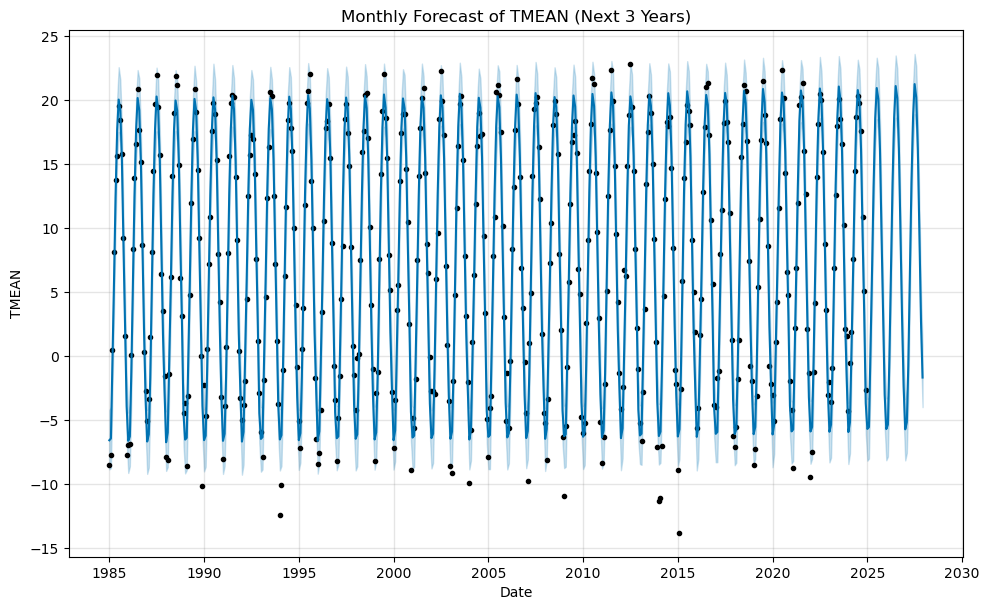

12:13:35 - cmdstanpy - INFO - Chain [1] start processing
12:13:35 - cmdstanpy - INFO - Chain [1] done processing



 Forecasting: PPT
 RMSE on Training Data (PPT): 26.80
            ds       yhat  yhat_lower  yhat_upper
480 2025-01-01  58.035997   26.657928   89.915323
481 2025-02-01  52.721915   23.754891   86.412926
482 2025-03-01  60.104462   27.914523   90.146548
483 2025-04-01  82.845108   50.213283  115.564345
484 2025-05-01  90.366302   56.488532  118.461602
485 2025-06-01  95.214259   61.608662  125.977299
486 2025-07-01  91.921603   58.661879  121.814524
487 2025-08-01  95.070549   61.398681  127.280470
488 2025-09-01  91.870266   59.104468  124.368005
489 2025-10-01  95.256219   63.289985  125.119836
490 2025-11-01  77.102197   45.825289  110.345235
491 2025-12-01  63.591330   33.735585   96.883727
492 2026-01-01  59.272412   29.912793   89.619363
493 2026-02-01  50.826603   18.516287   82.522719
494 2026-03-01  60.123183   28.504289   90.146309
495 2026-04-01  86.240900   54.451487  118.368992
496 2026-05-01  91.760045   61.019487  121.500528
497 2026-06-01  92.893869   61.225323  122.83

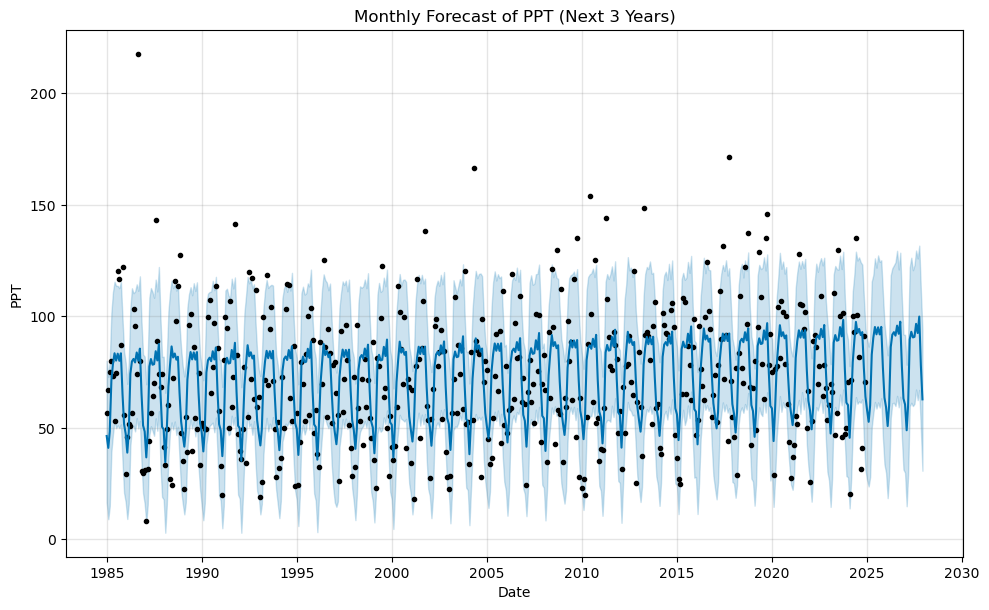

12:13:37 - cmdstanpy - INFO - Chain [1] start processing
12:13:37 - cmdstanpy - INFO - Chain [1] done processing



 Forecasting: TDMEAN
 RMSE on Training Data (TDMEAN): 6.18
            ds       yhat  yhat_lower  yhat_upper
480 2025-01-01  -8.424613  -10.887646   -5.929709
481 2025-02-01  -8.870598  -11.338153   -6.456603
482 2025-03-01  -4.687958   -6.973555   -2.390776
483 2025-04-01  -0.094038   -2.555772    2.132341
484 2025-05-01   6.252013    3.983594    8.772160
485 2025-06-01  12.284032    9.893293   14.652515
486 2025-07-01  15.281084   12.877328   17.607620
487 2025-08-01  15.198994   12.821280   17.684417
488 2025-09-01  11.690528    9.296270   13.984309
489 2025-10-01   5.208706    2.794562    7.504923
490 2025-11-01  -0.464794   -2.910949    1.856218
491 2025-12-01  -5.647130   -8.029357   -3.266330
492 2026-01-01  -8.390106  -10.570348   -5.809534
493 2026-02-01  -8.660613  -11.181437   -6.395312
494 2026-03-01  -5.155103   -7.713300   -2.776993
495 2026-04-01  -0.088048   -2.577427    2.358031
496 2026-05-01   6.404982    4.071069    8.913250
497 2026-06-01  12.333691    9.845112   

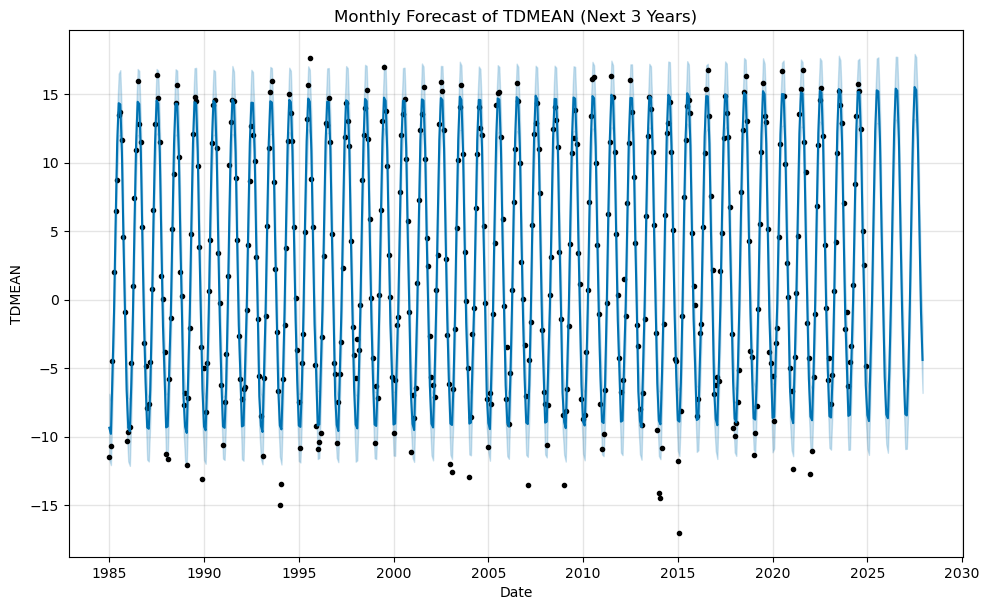

12:13:38 - cmdstanpy - INFO - Chain [1] start processing



 Forecasting: VPDMAX


12:13:38 - cmdstanpy - INFO - Chain [1] done processing


 RMSE on Training Data (VPDMAX): 4.48
            ds       yhat  yhat_lower  yhat_upper
480 2025-01-01   1.845345   -0.393734    3.953252
481 2025-02-01   2.581910    0.424417    4.756626
482 2025-03-01   4.958288    2.839589    7.100455
483 2025-04-01   8.995985    6.660035   11.073527
484 2025-05-01  13.826025   11.679817   15.936478
485 2025-06-01  17.449708   15.418613   19.593524
486 2025-07-01  18.958776   16.800741   21.158329
487 2025-08-01  16.788652   14.595111   18.790504
488 2025-09-01  13.314000   11.207814   15.457529
489 2025-10-01   8.262930    6.118709   10.318353
490 2025-11-01   4.307690    2.222702    6.324018
491 2025-12-01   2.146524    0.201066    4.366173
492 2026-01-01   1.836138   -0.431350    4.192086
493 2026-02-01   2.567830    0.348536    4.424823
494 2026-03-01   4.869111    2.729149    7.153279
495 2026-04-01   8.964992    6.839090   11.007327
496 2026-05-01  13.796078   11.549342   15.944304
497 2026-06-01  17.463616   15.170010   19.561829
498 2026-07-

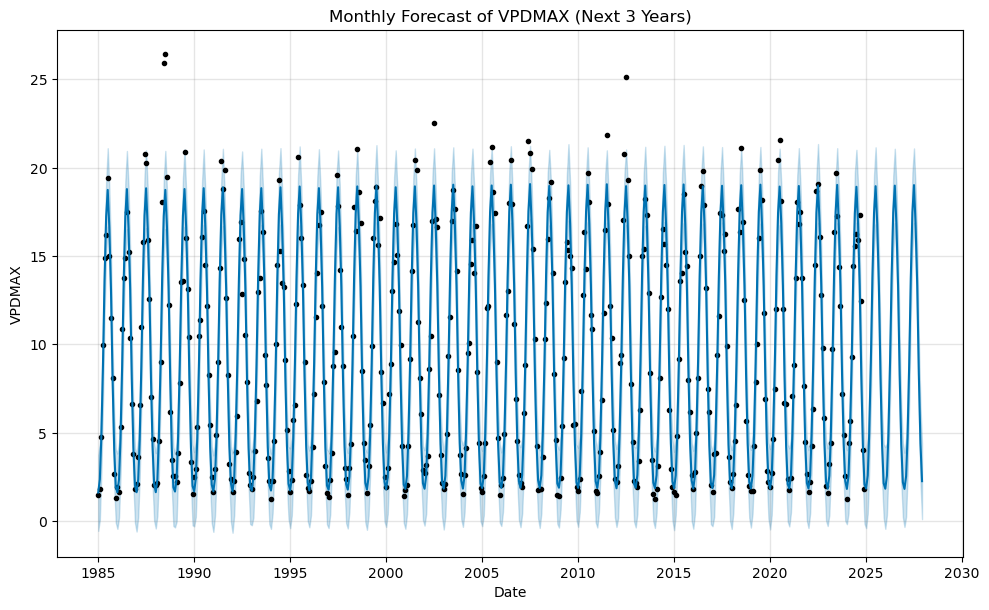

In [15]:
# Create datetime column
df['ds'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# List of climate variables to forecast
climate_vars = ['tmean', 'ppt', 'tdmean', 'vpdmax']

# Dictionary to store forecasts and RMSEs
all_forecasts = {}
rmse_scores = {}

# Loop through each variable
for var in climate_vars:
    print(f"\n Forecasting: {var.upper()}")
    
    # Prepare monthly data
    monthly_data = df[['ds', var]].dropna().rename(columns={var: 'y'})
    
    # Fit Prophet model
    m = Prophet(yearly_seasonality=True)
    m.fit(monthly_data)
    
    # Forecast next 36 months (3 years)
    future = m.make_future_dataframe(periods=36, freq='MS')
    forecast = m.predict(future)
    
    # Save forecast to dictionary
    all_forecasts[var] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
    
    # RMSE on training portion
    actual = monthly_data['y'].values
    predicted = forecast['yhat'].iloc[:len(actual)].values
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    rmse_scores[var] = rmse
    print(f" RMSE on Training Data ({var.upper()}): {rmse:.2f}")
    
    # Print last 36 forecasted months
    print(all_forecasts[var].tail(36))
    
    # Forecast plot
    fig1 = m.plot(forecast)
    plt.title(f"Monthly Forecast of {var.upper()} (Next 3 Years)")
    plt.xlabel("Date")
    plt.ylabel(var.upper())
    plt.grid(True)
    plt.show()

In [16]:
# DataFrame from the RMSE scores dictionary
rmse_table = pd.DataFrame([
    {'Variable': var.upper(), 'Prophet_RMSE': round(rmse, 2)}
    for var, rmse in rmse_scores.items()
])

# Display the table
print("\n Prophet RMSE Summary Table")
display(rmse_table)


 Prophet RMSE Summary Table


,Variable,Prophet_RMSE
0,TMEAN,6.72
1,PPT,26.80
2,TDMEAN,6.18
3,VPDMAX,4.48


<div align="center">
  <span style="color:#AC3E31; font-size:24px;"><strong>Prophet Forecast RMSE Interpretation</strong></span><br>
</div>

The RMSE values from the Prophet model show moderate forecasting accuracy across climate variables. While the model captures general trends, the relatively high RMSE for TMEAN (6.72) and TDMEAN (6.18) suggests Prophet struggled to precisely model temperature-related variables in this dataset. PPT (26.80) continues to show volatility, as expected, while VPDMAX (4.48) had the lowest RMSE, indicating comparatively better seasonal fit.
These results confirm that Prophet can model broad seasonal trends, but for improved accuracy especially in temperature forecasts - LSTM or SARIMA models may be more effective. The performance can serve as a baseline for comparing advanced models like LSTM.

<div align="center">
  <span style="color:#AC3E31; font-size:24px;"><strong>Forecasting tmean, ppt, tdmean, vdpmax for next 3 years (36 months) using LSTM Model</strong></span><br>
</div>

In [20]:
# Load data
df = pd.read_csv("Data/michigan_data.csv")

# Convert column names to lowercase just in case
df.columns = df.columns.str.lower()

# Create datetime column
df['ds'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

<div align="center">
  <span style="color:#AC3E31; font-size:24px;"><strong>LSTM Forecasting Function with Back-test</strong></span><br>
</div>

In [22]:
def forecast_lstm_with_backtest(variable, forecast_periods=36, window_size=12, epochs=50, test_size=60):
    print(f"\n Forecasting: {variable.upper()}")

    # Prepare the data
    df_clean = df[['ds', variable]].dropna().copy()
    df_clean = df_clean.set_index('ds')
    data = df_clean.values

    # Scale
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)

    # Train/Test Split
    split_idx = len(scaled) - test_size
    train, test = scaled[:split_idx], scaled[split_idx:]

    # Create sequences
    def create_seq(data, window):
        X, y = [], []
        for i in range(window, len(data)):
            X.append(data[i-window:i, 0])
            y.append(data[i, 0])
        return np.array(X), np.array(y)

    X_train, y_train = create_seq(train, window_size)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    # Train model
    model = Sequential([
        LSTM(64, return_sequences=False, input_shape=(window_size, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, verbose=0)

    # Backtest on test set
    X_test, y_test = create_seq(np.concatenate((train[-window_size:], test)), window_size)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    print(f" RMSE on backtest ({test_size} months): {rmse:.2f}")

    # Forecast 36 future months
    input_seq = scaled[-window_size:].reshape(1, window_size, 1)
    forecast_vals = []

    for _ in range(forecast_periods):
        next_val = model.predict(input_seq)[0][0]
        forecast_vals.append(next_val)
        input_seq = np.append(input_seq[:, 1:, :], [[[next_val]]], axis=1)

    forecast_vals = scaler.inverse_transform(np.array(forecast_vals).reshape(-1, 1))

    # Future dates
    last_date = df_clean.index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_periods, freq='MS')
    forecast_df = pd.DataFrame({'ds': future_dates, f'{variable}_forecast': forecast_vals.flatten()})

    # Plot full history + backtest + forecast
    plt.figure(figsize=(14, 6))
    plt.plot(df_clean.index, df_clean[variable], label='Actual')
    plt.plot(df_clean.index[-test_size:], y_pred, label='Backtest Prediction', color='green', linestyle='--')
    plt.plot(forecast_df['ds'], forecast_df[f'{variable}_forecast'], label='Forecast (36 Months)', color='orange')
    plt.title(f'{variable.upper()} | Backtest + 36-Month Forecast')
    plt.xlabel('Date')
    plt.ylabel(variable.upper())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Attach RMSE to forecast DataFrame
    forecast_df.attrs['rmse'] = rmse

    return forecast_df



 Forecasting: TMEAN
2/2 [==============================] - 1s 12ms/step
 RMSE on backtest (60 months): 2.46
1/1 [==============================] - 0s 63ms/step


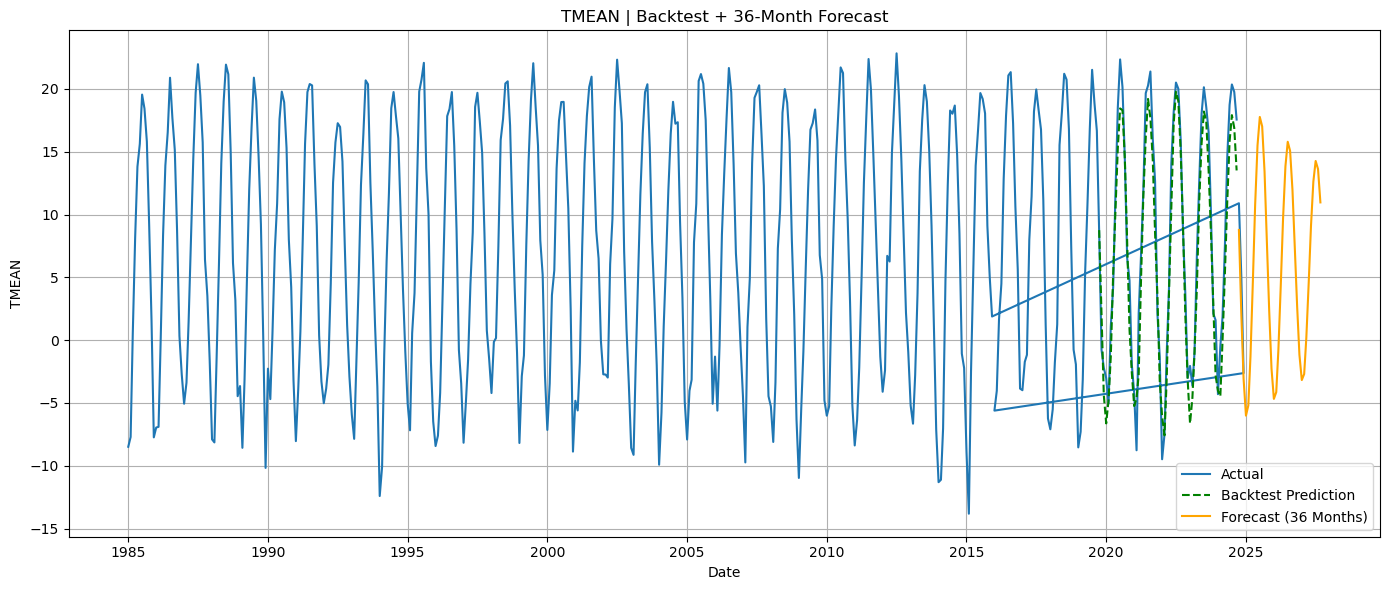


 Forecasting: PPT
2/2 [==============================] - 1s 23ms/step
 RMSE on backtest (60 months): 25.12
1/1 [==============================] - 0s 65ms/step


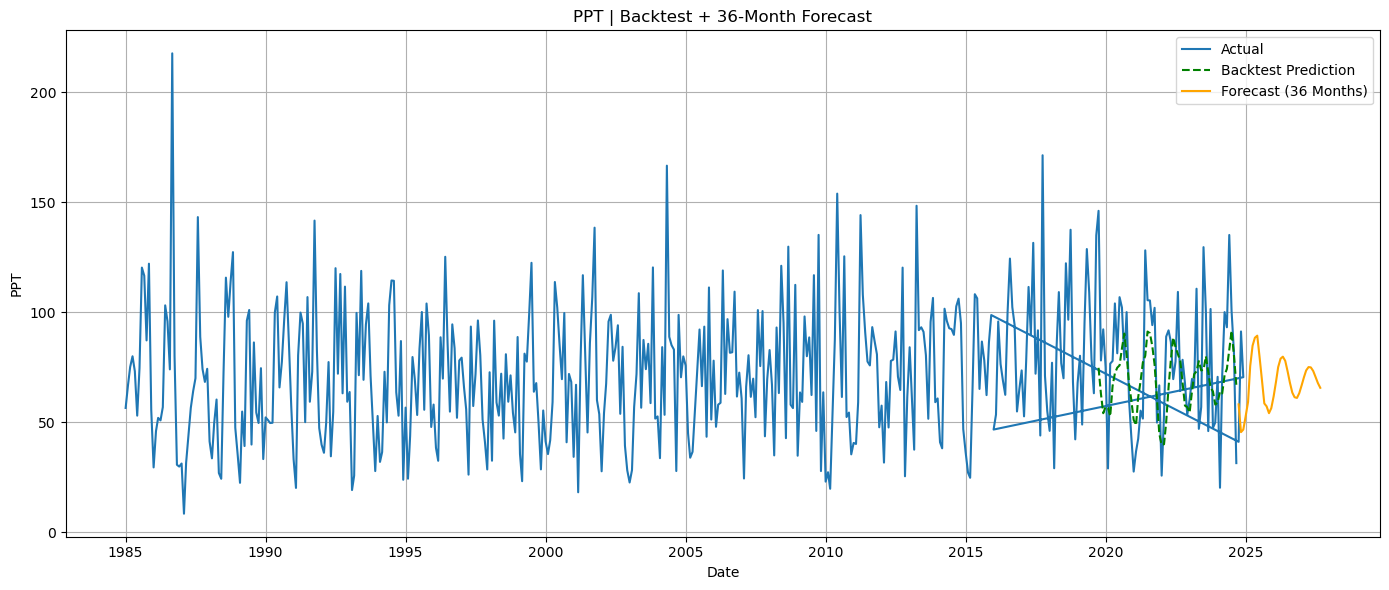


 Forecasting: TDMEAN
2/2 [==============================] - 1s 8ms/step
 RMSE on backtest (60 months): 2.02
1/1 [==============================] - 0s 52ms/step


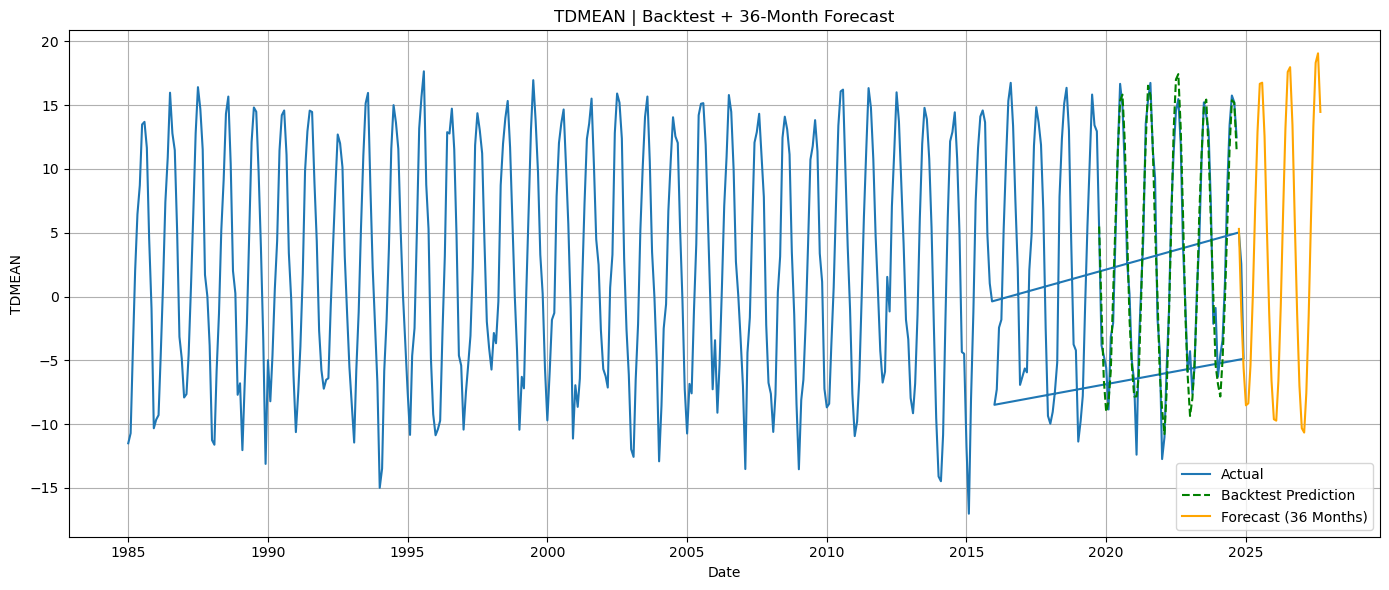


 Forecasting: VPDMAX
2/2 [==============================] - 1s 11ms/step
 RMSE on backtest (60 months): 1.62
1/1 [==============================] - 0s 63ms/step


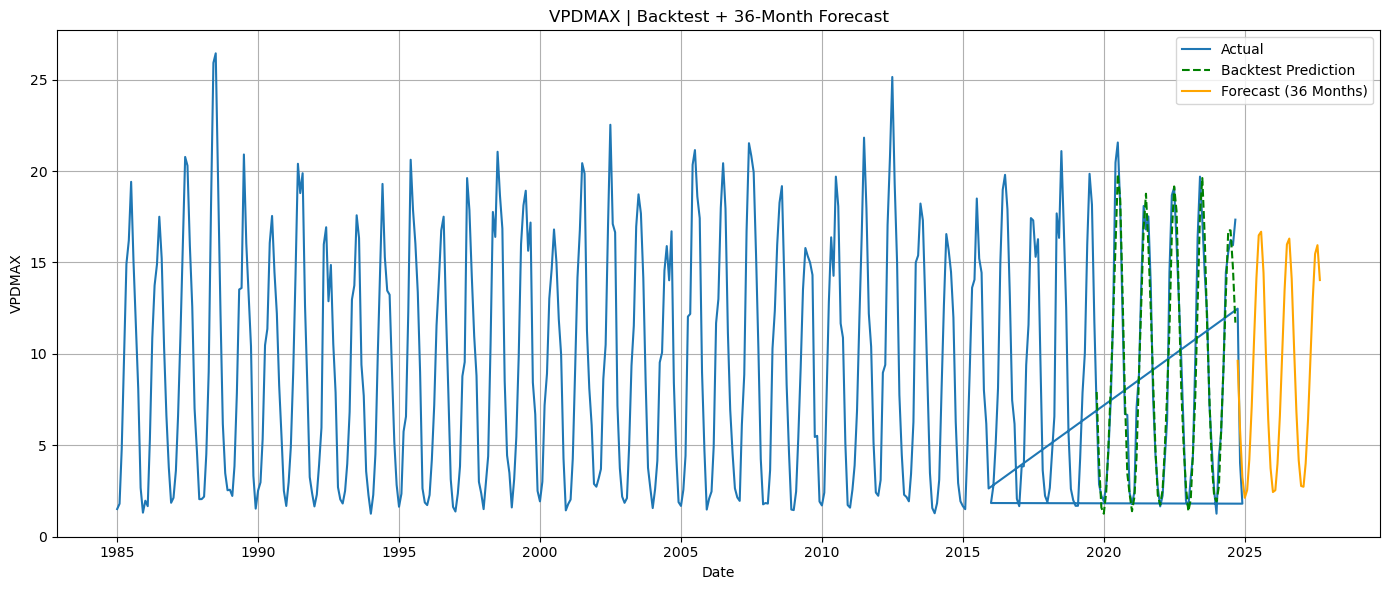

In [23]:
# List of variables to forecast
variables = ['tmean', 'ppt', 'tdmean', 'vpdmax']

# Dictionary to store each forecast
forecasts = {}
lstm_rmse_scores = {}

# Generate forecasts
for var in variables:
    forecast_df = forecast_lstm_with_backtest(variable=var)
    forecasts[var] = forecast_df
    # Capture RMSE from function output by modifying return
    rmse = forecast_df.attrs.get('rmse')
    lstm_rmse_scores[var.upper()] = round(rmse, 2)

In [42]:
# DataFrame from RMSE dictionary
rmse_table = pd.DataFrame([
    {'Variable': var, 'LSTM_RMSE': rmse}
    for var, rmse in lstm_rmse_scores.items()
])

# Display summary table
print("\n LSTM RMSE Summary Table")
display(rmse_table)


 LSTM RMSE Summary Table


,Variable,LSTM_RMSE
0,TMEAN,2.46
1,PPT,25.12
2,TDMEAN,2.02
3,VPDMAX,1.62


<div align="center">
  <span style="color:#AC3E31; font-size:24px;"><strong>LSTM Forecast RMSE Interpretation</strong></span><br>
</div>
The LSTM model delivered strong performance across all climate variables, with significantly lower RMSEs compared to the Prophet and Seasonal Naive baselines.

* TMEAN (2.46) and TDMEAN (2.02) show excellent alignment with historical temperature and moisture trends, capturing seasonality and variability effectively.
* VPDMAX achieved the lowest RMSE at 1.62, indicating that LSTM models vapor pressure deficit trends very reliably.
* PPT (Precipitation), though still the most variable, saw a notable improvement over Prophet (26.80) and Seasonal Naive (35.00), reducing RMSE to 25.12.

These results confirm that LSTM outperforms Prophet for all variables and is especially suitable for modeling temperature and moisture-driven climate behavior in Michigan.

<div align="center">
  <span style="color:#AC3E31; font-size:24px;"><strong>Key Insights</strong></span><br>
</div>
LSTM consistently outperformed both Prophet and Seasonal Naive models in terms of accuracy. The LSTM model captured complex seasonal fluctuations and provided the lowest RMSEs across all variables, making it the most effective tool for long-term climate forecasting in this analysis. 